# Given an Image with bbox coordinates, square it, downsize it and replot the bbox

Image preprocessing is often a challenge in preparing data for deep learning training jobs. One requirement is that images need to be of the same size and preferrably lower resolution. Any box annotations within the image should also be mantained. This example uses a landscape and portrait image, which it first squares by padding, then reduces the size and mantains the box annotations.

In [62]:
from PIL import Image, ImageOps, ImageDraw
from matplotlib.pyplot import imshow
import numpy as np

In [63]:
def show_image_inline(pil_img):
    %matplotlib inline
    imshow(np.asarray(pil_img))

In [64]:
l_pic = "dog_landscape.jpg"
p_pic = "dog_portrait.jpg"

# Figured this out using https://github.com/wkentaro/labelme
l_dog_cord = [821, 182, 1299, 1152] #xmin, ymin, xmax, ymax for landscape dog
p_dog_cord = [242, 65, 626, 951] #xmin, ymin, xmax, ymax for portrait dog

Width : 2048 Height: 1365


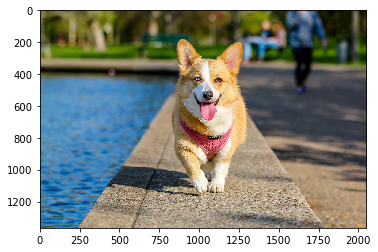

In [65]:
landscape_orig = Image.open(l_pic, 'r')
show_image_inline(landscape_orig)
print "Width : %d Height: %d" %(landscape_orig.size[0], landscape_orig.size[1])

Width : 800 Height: 1000


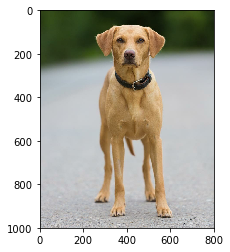

In [66]:
portrait_orig = Image.open(p_pic, 'r')
show_image_inline(portrait_orig)
print "Width : %d Height: %d" %(portrait_orig.size[0], portrait_orig.size[1])

## Draw boxes on images

In [67]:
#Draw a box on an image
def draw_box(pil_img, coord, weight=1):
    draw = ImageDraw.Draw(pil_img)
    # Simulate line weight by drawing multiple rectangles
    for i in xrange(weight):
        draw.rectangle(((coord[0]+i, coord[1]+i), (coord[2]+i, coord[3]+i)), outline="red")
    return pil_img

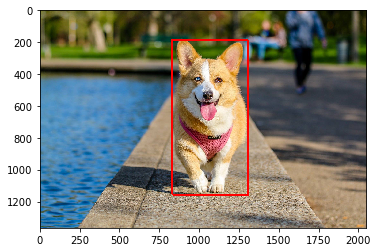

In [68]:
landscape_orig_box = draw_box(landscape_orig.copy(), l_dog_cord, weight=10)
show_image_inline(landscape_orig_box)

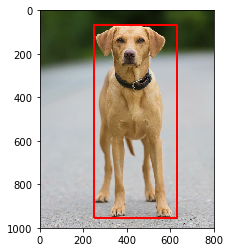

In [69]:
portrait_orig_box = draw_box(portrait_orig.copy(), p_dog_cord, weight=10)
show_image_inline(portrait_orig_box)


## Pad image on bottom edge or right edge

In [70]:
def pad_image(pil_img):
    width, height = pil_img.size
    desired_size = max(width, height)
    # Calculate total padding required
    delta_w = desired_size - width
    delta_h = desired_size - height
    # Padding is applied on the right and bottom edges only, one of these will be 0
    padding = (0, 0, delta_w, delta_h)
    new_im = ImageOps.expand(pil_img, padding)
    return new_im

Width : 2048 Height: 2048


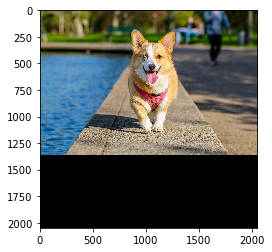

In [71]:
landscape_padded = pad_image(landscape_orig.copy())
print "Width : %d Height: %d" %(landscape_padded.size[0], landscape_padded.size[1])
show_image_inline(landscape_padded)

Width : 1000 Height: 1000


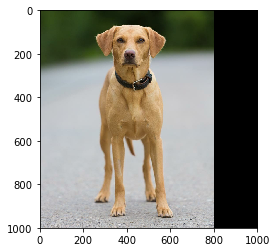

In [72]:
portrait_padded = pad_image(portrait_orig.copy())
print "Width : %d Height: %d" %(portrait_padded.size[0], portrait_padded.size[1])
show_image_inline(portrait_padded)

## Can you still draw boxes correctly on the padded images?

You should be able to because the paddings are added either to the bottom edge or right edge, thereby not affecting box co-ordinates on the original image

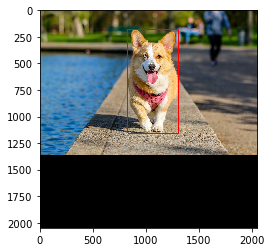

In [73]:
landscape_padded_box = draw_box(landscape_padded.copy(), l_dog_cord, weight=10)
show_image_inline(landscape_padded_box)

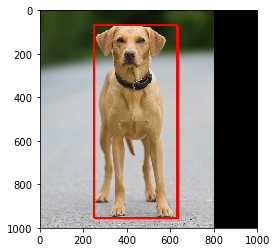

In [74]:
portrait_padded_box = draw_box(portrait_padded.copy(), p_dog_cord, weight=10)
show_image_inline(portrait_padded_box)

## Reduce the image size

Reduce the padded image to a smaller square

In [75]:
def resize_square_img(pil_img, edge_length):
    size = (edge_length, edge_length)
    resized_image = pil_img.resize(size, Image.ANTIALIAS)
    return resized_image
    

Width : 512 Height: 512


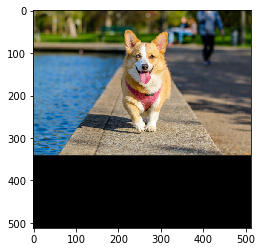

In [76]:
landscape_resized = resize_square_img(landscape_padded.copy(), 512)
show_image_inline(landscape_resized)
print "Width : %d Height: %d" %(landscape_resized.size[0], landscape_resized.size[1])


Width : 512 Height: 512


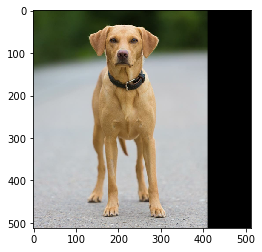

In [77]:
portrait_resized = resize_square_img(portrait_padded.copy(), 512)
show_image_inline(portrait_resized)
print "Width : %d Height: %d" %(portrait_resized.size[0], portrait_resized.size[1])

## Normalize co-ordinates
Usually neural nets will require the bbox co-ordinates to be between 0 and 1. So for each x, y co-ordinate you can figure out their normalized co-orindates by simply dividing by the image size. Because of this normalized co-ordinates should be agnostic to the image size, hence they should carry over to the reduced image size

In [78]:
def get_normalized_coordinates(pil_img, coord):
    # Returns [xmin, ymin, xmax, ymax] normalized coordinates. expects the same format in coord
    w, h = pil_img.size
    n_xmin = float(coord[0])/float(w)
    n_ymin = float(coord[1])/float(h)
    n_xmax = float(coord[2])/float(w)
    n_ymax = float(coord[3])/float(h)
    return [n_xmin, n_ymin, n_xmax, n_ymax]

In [79]:
norm_l_dog_cord = get_normalized_coordinates(landscape_padded, l_dog_cord)
norm_p_dog_cord = get_normalized_coordinates(portrait_padded, p_dog_cord)

## Can you draw boxes on the reduced image using normalized coordinates?
You should be able to, if you follwed this far

Width : 512 Height: 512


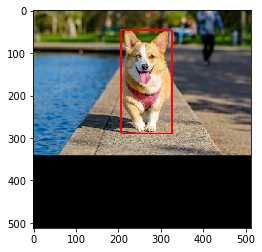

In [80]:
new_coord = [norm_l_dog_cord[0] * 512, norm_l_dog_cord[1] * 512, norm_l_dog_cord[2] * 512, norm_l_dog_cord[3] * 512 ]
landscape_resized_padded_box = draw_box(landscape_resized.copy(), new_coord, weight=4)
show_image_inline(landscape_resized_padded_box)
print "Width : %d Height: %d" %(landscape_resized_padded_box.size[0], landscape_resized_padded_box.size[1])

Width : 512 Height: 512


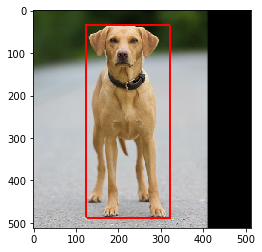

In [81]:
new_coord = [norm_p_dog_cord[0] * 512, norm_p_dog_cord[1] * 512, norm_p_dog_cord[2] * 512, norm_p_dog_cord[3] * 512 ]
portrait_resized_padded_box = draw_box(portrait_resized.copy(), new_coord, weight=4)
show_image_inline(portrait_resized_padded_box)
print "Width : %d Height: %d" %(portrait_resized_padded_box.size[0], portrait_resized_padded_box.size[1])

## You are done!
Reduced images are landscape_resized_padded and portrait_resized_padded. The norm_l_dog_cord and norm_p_dog_cord indicate normalized bbox co-ordinates for both the landscape and portrait images respectively. You can now use these in your protocol buffers like tfrecords or alternatives, ready for input into your Neural net.